#### In this demo we'll be building a machine learning model to go from once sequence to another, using PyTorch and TorchText. This will be done on German to English translations https://www.manythings.org/anki/ (download the data from here)

In [1]:
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

The most common sequence-to-sequence (seq2seq) models are encoder-decoder models, which (commonly) use a recurrent neural network (RNN) to encode the source (input) sentence into a single vector.

#### we will be representing each word in a language as a one-hot vector.We’ll need a unique index per word to use as the inputs and targets of the networks later.

we will use a helper class called Lang which has word → index (word2index) and index → word (index2word) dictionaries, as well as a count of each word word2count to use to later replace rare words.

In [2]:
SOS_token = 0
EOS_token = 1

In [3]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

#### The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation.

In [4]:
def normalizeString(s):
    
    s = s.lower().strip()
    
    s = ''.join(
        char for char in unicodedata.normalize('NFD', s)
        if unicodedata.category(char) != 'Mn')
    
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    
    return s

#### - To read the data file we will split the file into lines
#### - then split lines into pairs and normalize
#### - The files are all English → German, to translate German → English add reverse flag to reverse the pairs

In [5]:
def readLangs(lang1, lang2, reverse = False):
    
    print("Reading lines...")

    lines = open('datasets/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8'). \
                  read().strip().split('\n')

    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

#### Since there are a lot of example sentences and we want to train something quickly, we’ll trim the data set to only relatively short and simple sentences. Here the maximum length is 10 words (that includes ending punctuation) and we’re filtering to sentences that translate to the form “I am” or “He is” etc. (accounting for apostrophes replaced earlier).

In [6]:
MAX_LENGTH = 10

In [7]:
eng_prefixes = ("i am ", "i m ",
                "he is", "he s ",
                "she is", "she s ",
                "you are", "you re ",
                "we are", "we re ",
                "they are", "they re ")

In [8]:
def filterPairs(pairs):
    return [p for p in pairs if 
            len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)]

- Read text file and split into lines, split lines into pairs
- Normalize text, filter by length and content
- Make word lists from sentences in pairs

In [9]:
def prepareData(lang1, lang2, reverse = False):
    
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs

In [10]:
input_lang, output_lang, pairs = prepareData('eng', 'deu', True)

print(random.choice(pairs))

Reading lines...
Read 176692 sentence pairs
Trimmed to 9678 sentence pairs
Counted words:
deu 4494
eng 2913
['sie ist ein ziemlich cleveres madchen .', 'she is quite a clever girl .']


#### Encoder-Decoder
A Sequence to Sequence network, or seq2seq network, or Encoder Decoder network, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence

In [11]:
class EncoderRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

#### Basic Decoder(will not be using this in the course)

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string SOS token, and the first hidden state is the context vector (the encoder’s last hidden state).

In [17]:
class DecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

#### Attention Decoder 
If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.



In [18]:
# class AttnDecoderRNN(nn.Module):
    
#     def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length = MAX_LENGTH):
#         super(AttnDecoderRNN, self).__init__()
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         self.dropout_p = dropout_p
#         self.max_length = max_length

#         self.embedding = nn.Embedding(self.output_size, self.hidden_size)
#         self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
#         self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
#         self.dropout = nn.Dropout(self.dropout_p)
#         self.gru = nn.GRU(self.hidden_size, self.hidden_size)
#         self.out = nn.Linear(self.hidden_size, self.output_size)

#     def forward(self, input, hidden, encoder_outputs):
#         embedded = self.embedding(input).view(1, 1, -1)
#         embedded = self.dropout(embedded)

#         attn_weights = F.softmax(
#             self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
#         attn_applied = torch.bmm(attn_weights.unsqueeze(0),
#                                  encoder_outputs.unsqueeze(0))

#         output = torch.cat((embedded[0], attn_applied[0]), 1)
#         output = self.attn_combine(output).unsqueeze(0)

#         output = F.relu(output)
#         output, hidden = self.gru(output, hidden)

#         output = F.log_softmax(self.out(output[0]), dim=1)
#         return output, hidden, attn_weights

#     def initHidden(self):
#         return torch.zeros(1, 1, self.hidden_size)


#### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [19]:
def tensorFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

In [20]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the SOS token as its first input, and the last hidden state of the encoder as its first hidden state.

<b>“Teacher forcing” </b> is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input.
    
    

In [21]:
teacher_forcing_ratio = 0.5

In [23]:
def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion,
          max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]])

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
       
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  

    else:
        
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

In [24]:
plot_losses = []
print_loss_total = 0  
plot_loss_total = 0 

In [25]:
hidden_size = 256

In [27]:
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)
attn_decoder1 = DecoderRNN(hidden_size, output_lang.n_words)

In [28]:
encoder_optimizer = optim.SGD(encoder1.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(attn_decoder1.parameters(), lr=0.01)

training_pairs = [tensorsFromPair(random.choice(pairs))
                  for i in range(30000)]
criterion = nn.NLLLoss()

In [29]:
for iter in range(1, 30001):
    
    training_pair = training_pairs[iter - 1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    loss = train(input_tensor, target_tensor, encoder1,
                 attn_decoder1, encoder_optimizer, decoder_optimizer, criterion)
    
    print_loss_total += loss
    plot_loss_total += loss

    if iter % 1000 == 0:
        print_loss_avg = print_loss_total / 100
        print_loss_total = 0
        print('iteration - %d loss - %.4f' % (iter, print_loss_avg))

    if iter % 100 == 0:
        plot_loss_avg = plot_loss_total / 100
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

fig, ax = plt.subplots(figsize=(15, 8))
loc = ticker.MultipleLocator(base=0.2)
ax.yaxis.set_major_locator(loc)
plt.plot(plot_losses)

TypeError: forward() takes 3 positional arguments but 4 were given

#### KEY: > input = target < output

#### Evaluation
there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. 

In [61]:
def evaluate(encoder, decoder, sentence, max_length = MAX_LENGTH):
    
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]])  
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                                        decoder_hidden, 
                                                                        encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
                
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [65]:
for i in range(10):
        
        pair = random.choice(pairs)
        
        print('>', pair[0])
        print('=', pair[1])
        
        output_words, attentions = evaluate(encoder1, attn_decoder1, pair[0])
        output_sentence = ' '.join(output_words)
        
        print('<', output_sentence)
        print('')

> wir sind recht stolz auf uns selbst .
= we re pretty proud of ourselves .
< we re proud of us . <EOS>

> du bist brav oder ?
= you re good aren t you ?
< you re new aren t you ? <EOS>

> er ist sehr begierig darauf dorthin zu gehen .
= he is very eager to go there .
< he is very fond of go . <EOS>

> wir gehen .
= we re leaving .
< we re going . <EOS>

> er ist in unserem land sehr bekannt .
= he is well known in our country .
< he is very good at our new . <EOS>

> ich fange allmahlich an es zu bereuen .
= i m beginning to regret it .
< i am trying to regret it . <EOS>

> ich bin opa .
= i m a grandfather .
< i m a . <EOS>

> wir sind seine sohne .
= we are his sons .
< we are his his . <EOS>

> er ist des lesens mude .
= he is tired of reading .
< he s tired of reading . <EOS>

> sie ist viel gro er als ich .
= she s way taller than me .
< she s much taller than me . <EOS>



#### Visualizing Attention
We could simply run plt.matshow(attentions) to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

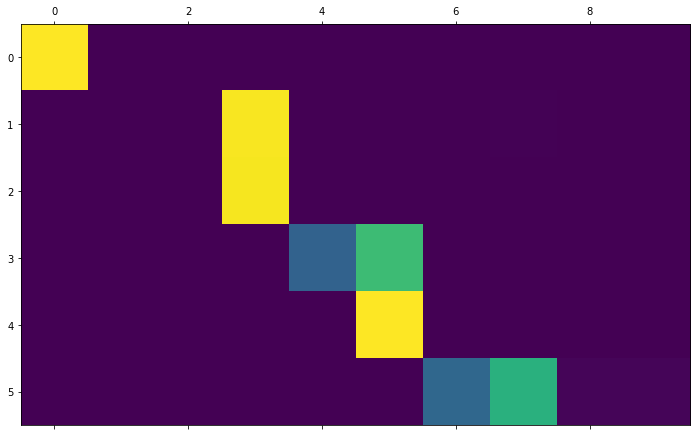

In [66]:
output_words, attentions = evaluate(encoder1, 
                                    attn_decoder1, 
                                    'es tut mir sehr leid')

plt.figure(figsize = (12, 10))
plt.matshow(attentions.numpy(), fignum=1)

##### Evaluate and Visualise

In [67]:
input_sentence = 'es tut mir sehr leid' #Re-run for 'es geht mir gut'

In [68]:
output_words, attentions = evaluate(encoder1, 
                                    attn_decoder1, 
                                    input_sentence)

In [69]:
print('input =', input_sentence)
print('output =', ' '.join(output_words))

input = es tut mir sehr leid
output = i am very sorry . <EOS>


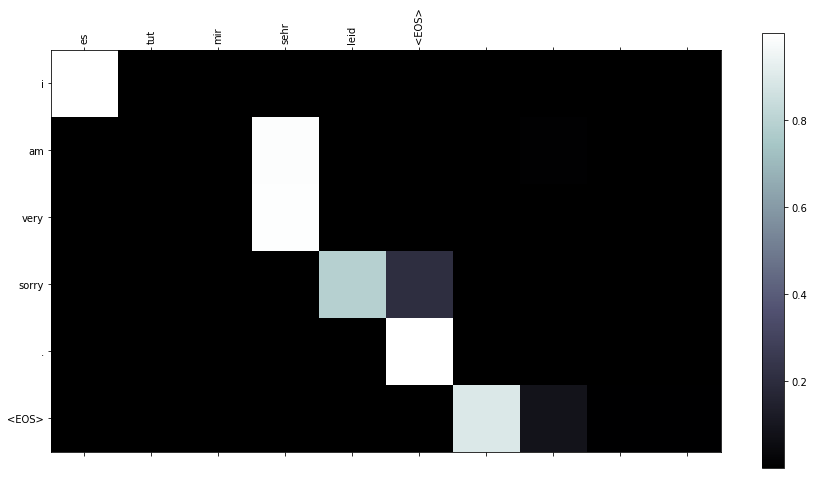

In [75]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(attentions.numpy(), cmap='bone')
fig.colorbar(cax)


ax.set_xticklabels([''] + input_sentence.split(' ') +
                   ['<EOS>'], rotation=90)
ax.set_yticklabels([''] + output_words)


ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()